In [1]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade
# install joblib. This will be used to save your model. 
# Restart your kernel after installing 
!pip install joblib

This model uses a neural network and GridSearchCV to predict share price impacts of Interest changes

# Read the CSV and Perform Basic Data Cleaning

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
df_stock1 = pd.read_csv("../../static/data/wes.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
8859,1/08/2022,46.590000,46.974998,46.220001,46.750000,46.750000,1963566.0,1.35,2.5,125.0
8860,2/08/2022,46.849998,47.590000,46.610001,47.570000,47.570000,1503797.0,1.35,2.5,125.0
8861,3/08/2022,47.150002,47.240002,46.549999,47.049999,47.049999,1629520.0,1.85,2.5,125.0
8862,4/08/2022,47.580002,47.810001,46.959999,47.000000,47.000000,1319580.0,1.85,2.5,125.0
8863,5/08/2022,47.200001,47.680000,47.110001,47.599998,47.599998,243025.0,1.85,2.5,125.0


In [4]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

df_mongo = pd.DataFrame(list(db.wes.find()))
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
# print(last_val)
print(last_date,last_close)
df_mongo.tail


12/08/2022 47.2400016784668


<bound method NDFrame.tail of                            _id        Date       Open       High        Low  \
0     62eccae32574e28410eef1f1   1/02/1988   1.322599   1.322599   1.322599   
1     62eccae32574e28410eef1f2   2/02/1988   1.322599   1.322599   1.322599   
2     62eccae32574e28410eef1f3   3/02/1988   1.322599   1.322599   1.322599   
3     62eccae32574e28410eef1f4   4/02/1988   1.322599   1.322599   1.322599   
4     62eccae32574e28410eef1f5   5/02/1988   1.322599   1.322599   1.322599   
...                        ...         ...        ...        ...        ...   
8698  62f21d8b0eb7abb42397fc14  08/08/2022  47.410000  47.470001  46.689999   
8699  62f370d64fe8cc535ec365ea  09/08/2022  46.849998  47.630001  46.849998   
8700  62f700018e06f07caad4343c  10/08/2022  47.020000  47.500000  46.849998   
8701  62f700018e06f07caad4343d  11/08/2022  47.400002  48.049999  47.389999   
8702  62f700018e06f07caad4343e  12/08/2022  47.270000  47.419998  46.959999   

          Close  Adj 

# Use `RBA`,`FED` and `CPI` for the X values

In [5]:
X = df_mongo[["RBA","FED","CPI"]]
y = df_mongo["Close"].values.reshape(-1, 1)
print(X.shape, y.shape)

(8703, 3) (8703, 1)


In [6]:
# X = df_mongo[["RBA","FED","CPI"]]
# y = df_mongo["Close"].values.reshape(-1, 1)
# print(X.shape, y.shape)

In [7]:
y

array([[ 1.322599  ],
       [ 1.322599  ],
       [ 1.322599  ],
       ...,
       [47.04000092],
       [48.04999924],
       [47.24000168]])

# Create a Train Test Split

In [8]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_train.info)

(6527, 3) (6527, 1)
(2176, 3) (2176, 1)
<bound method DataFrame.info of         RBA   FED    CPI
5309   3.25  0.25   92.5
2563   5.00  5.50   67.4
5435   3.00  0.25   93.8
1503   4.75  3.25   61.5
4165   5.25  1.50   80.9
...     ...   ...    ...
2895   5.00  5.50   68.7
7813   1.50  2.50  114.1
905    9.50  5.25   59.3
5192   7.00  2.00   92.7
235   17.50  9.97   51.7

[6527 rows x 3 columns]>


In [9]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fit the model

In [10]:
# Fit the model to the training data and calculate the scores for the training and testing data

### BEGIN SOLUTION
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

### END SOLUTION 

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.8808152552859061
Testing Score: 0.8732763900026441


In [11]:
# X_train = X_train.reshape((X_train.shape[0], 1))

In [12]:
#Linear Regression Residual showing difference actual vs predicted
# residual = pd.DataFrame([model.predict(X_train),y_train,(model.predict(X_train)-y_train)])
# residual.tail

Text(0.5, 1.0, 'Residual Plot')

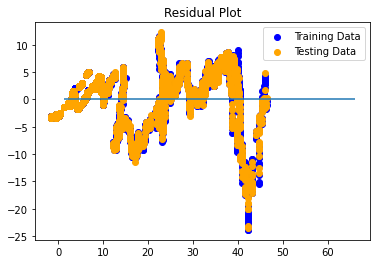

In [13]:
# Plot the Residuals for the Training and Testing data
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")

In [14]:
# Linear Regression: X_test predictions to variable
predictions = model.predict(X_test)

#### R2 Score is a very popular metric used for evaluating the performance of linear regression models. Where R2 Score is between 0 and 1, the closer to 1, the better the regression fit.
#### Use MSE or MAE when comparing two or more models, the lower the value of MSE or MAE, the better. MSE (Mean Square Error): Uses Euclidean distance to calculate the error. MSE gives the magnitude of the error only.

In [15]:
# Used X_test, y_test, and model.predict(X_test) to calculate MSE and R2

### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 23.596614721052926, R2: 0.8732763900026441


#### Lasso regression imposes a constraint on the model parameters that causes regression coefficients for some variables to shrink toward zero. It comes with a parameter, alpha , and the higher the alpha , the more feature coefficients are zero. When alpha is 0 , Lasso regression produces the same coefficients as a linear regression.

In [16]:
# LASSO model
# Note: Used an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train, y_train)

predictions = lasso.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = lasso.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 23.597747506885177, R2: 0.873270306472794


In [17]:
# Ridge model
# Note: Used an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train, y_train)

predictions = ridge.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = ridge.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 23.59661481395629, R2: 0.8732763895037144


In [18]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train, y_train)

predictions = elasticnet.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = elasticnet.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 23.597482454920492, R2: 0.8732717299117999


# Hyperparameter Tuning

In [19]:
y_target = df_mongo["Close"]
y_target.shape

(8703,)

In [20]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_target, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6527, 3) (6527,)
(2176, 3) (2176,)


In [21]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(6527, 3) (6527,)
(2176, 3) (2176,)


#### GridSearchCV and RandomizedSearchCV are techniques to evaluate models for a given hyperparameter vector using cross-validation, hence the “CV” suffix of the class name.
#### We are executing many models together is to find which machine learning model works best for this particular dataset.

In [22]:
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [23]:
regressors = [
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge()
]

In [24]:
from time import time
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

RandomForestRegressor()
	Training time: 0.572s
	Prediction time: 0.069s
	Explained variance: 0.9960952880072804
	Mean absolute error: 0.539544510625061
	R2 score: 0.9960949316785304

DecisionTreeRegressor()
	Training time: 0.006s
	Prediction time: 0.001s
	Explained variance: 0.9961010586172885
	Mean absolute error: 0.538833275879794
	R2 score: 0.9961007640303794

KNeighborsRegressor()
	Training time: 0.005s
	Prediction time: 0.010s
	Explained variance: 0.9954467526349167
	Mean absolute error: 0.5617074480122511
	R2 score: 0.9954467522773397

GradientBoostingRegressor()
	Training time: 0.336s
	Prediction time: 0.007s
	Explained variance: 0.9938216590632003
	Mean absolute error: 0.7492625424954844
	R2 score: 0.9938216025218864

KNeighborsRegressor()
	Training time: 0.006s
	Prediction time: 0.021s
	Explained variance: 0.9954467526349167
	Mean absolute error: 0.5617074480122511
	R2 score: 0.9954467522773397

ExtraTreesRegressor()
	Training time: 0.477s
	Prediction time: 0.043s
	Explained v

#### By comparing these results, we can quickly see that RandomForestRegressor and DecisionTreeRegressor are the best models for our data
#### Machine learning models have parameters, which are the internal coefficients set by training or optimizing the model on a training dataset.
#### Parameters are different from hyperparameters. Parameters are learned automatically; hyperparameters are set manually to help guide the learning process.

In [25]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [26]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [27]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [28]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

In [29]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.5395 degrees.
Accuracy = 97.18%.
Model Performance
Average Error: 0.5388 degrees.
Accuracy = 97.19%.
Improvement of 0.00%.


In [30]:
base_accuracy

97.18258136289644

In [31]:
# Hyperparameter tuning has not improved accuracy significantly

In [32]:
model_rfr = RandomForestRegressor()
model_rfr.fit(X_train, y_train)
y_test_pred = model_rfr.predict(X_test)
y_test_pred

array([15.8908034 , 20.37247712, 28.90321384, ..., 18.42734929,
       31.07718284, 28.7703707 ])

In [33]:
#RandomForestRegressor Residual showing difference actual vs predicted
residual_dtr = pd.DataFrame([model_rfr.predict(X_train),y_train,(model_rfr.predict(X_train)-y_train)])
residual_dtr.tail

<bound method NDFrame.tail of         0         1          2         3          4         5          6     \
0  12.653030  8.560686  18.427349  5.855688  20.372477  4.046384  19.117988   
1  13.404621  8.503389  18.552347  5.690432  20.298344  3.742007  19.886990   
2  -0.751591  0.057297  -0.124998  0.165256   0.074133  0.304377  -0.769002   

        7          8          9     ...       6517       6518       6519  \
0  26.491069  27.287653  15.890803  ...  21.150114  32.997578  24.983167   
1  29.272701  27.522264  14.717140  ...  21.005251  33.768875  25.280357   
2  -2.781632  -0.234611   1.173663  ...   0.144863  -0.771297  -0.297190   

       6520       6521      6522       6523          6524       6525      6526  
0  2.535577  25.007683  9.474211  33.171755  2.632308e+00  20.981809  2.983808  
1  2.549589  24.667704  9.694730  33.299999  2.632308e+00  20.327442  2.944776  
2 -0.014012   0.339979 -0.220519  -0.128244 -3.108624e-15   0.654367  0.039032  

[3 rows x 6527 columns]

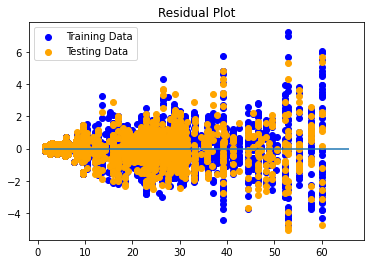

In [34]:
# Make predictions using fitted model
predictions1 = model_rfr.predict(X_test)

# Plotted the difference between the model predicted values and actual y values, versus the model predicted values
plt.scatter(model_rfr.predict(X_train), y_train - model_rfr.predict(X_train), c="blue", label="Training Data")
plt.scatter(model_rfr.predict(X_test), y_test - model_rfr.predict(X_test), c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

# Save the Model

In [35]:
import pickle
filename = '../../static/wes_model_rfr.sav'
pickle.dump(model, open(filename, 'wb'))
model_in_rfr = pickle.load(open(filename, 'rb'))

In [36]:
# from joblib import dump,load
# model_in_rfr = load('wes_model_rfr.sav')

In [37]:
rba = float(1.35)
fed = float(1.75)
cpi = float(123.90)
input =40
rfr=[]

def randomforest(rba,fed,cpi):
    for i in range(0,input):
      rfr.append([rba,fed,cpi])
      np.round_(rfr,2,out = None) 
      df = pd.DataFrame(rfr, columns = ['RBA','FED',"CPI"])
      df.round(2)
      pred_rf=model_in_rfr.predict(df)
      df['Prediction'] = pred_rf
      df['Prediction'] = df['Prediction'].astype(float).round(2)
      rba+=0.25
      fed+=0.25
      cpi+=0.25
      # print(df)
    my_rforest = df.to_dict(orient='records')
    for dict_value in my_rforest:
      for k, v in dict_value.items():
        dict_value[k] = round(v, 2)
    return my_rforest,df
# print(my_rforest)
my_rf,df = randomforest(rba,fed,cpi)
print(df,my_rf)


      RBA    FED     CPI  Prediction
0    1.35   1.75  123.90       45.08
1    1.60   2.00  124.15       45.40
2    1.85   2.25  124.40       45.72
3    2.10   2.50  124.65       46.05
4    2.35   2.75  124.90       46.37
5    2.60   3.00  125.15       46.69
6    2.85   3.25  125.40       47.01
7    3.10   3.50  125.65       47.33
8    3.35   3.75  125.90       47.66
9    3.60   4.00  126.15       47.98
10   3.85   4.25  126.40       48.30
11   4.10   4.50  126.65       48.62
12   4.35   4.75  126.90       48.95
13   4.60   5.00  127.15       49.27
14   4.85   5.25  127.40       49.59
15   5.10   5.50  127.65       49.91
16   5.35   5.75  127.90       50.23
17   5.60   6.00  128.15       50.56
18   5.85   6.25  128.40       50.88
19   6.10   6.50  128.65       51.20
20   6.35   6.75  128.90       51.52
21   6.60   7.00  129.15       51.84
22   6.85   7.25  129.40       52.17
23   7.10   7.50  129.65       52.49
24   7.35   7.75  129.90       52.81
25   7.60   8.00  130.15       53.13
2

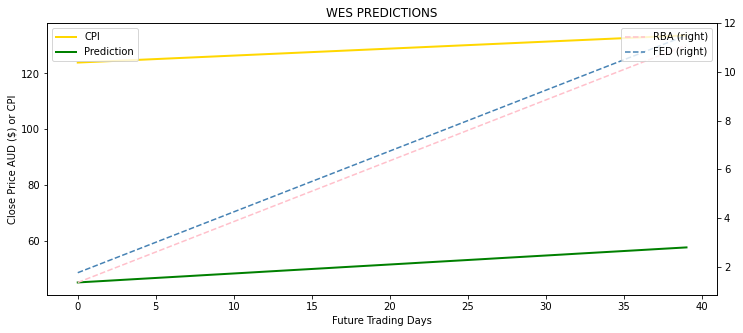

In [38]:
# DRAW THE PREDICTION
#Append the input amount of trading days to dates dictionary
input=40
# df_pred = df.iloc[0:(input-1)]
plot1 = df.plot(y=["CPI","Prediction"], figsize=(12, 5),color=['gold','green'],linewidth=2)
plot2 = df.plot(y=["RBA","FED"],secondary_y=True, ax=plot1,color=['pink','steelblue'],linestyle='dashed')
plt.title('WES PREDICTIONS')
plot1.set_xlabel('Future Trading Days', fontsize=10)
plot1.set_ylabel('Close Price AUD ($) or CPI', fontsize=10)
plot1.legend(loc='upper left')
plot2.legend(loc='upper right')
plt.savefig('../../static/data/images/wes_rfr_pred.png', bbox_inches="tight")
plt.show()

In [39]:
rba = float(1.35)
fed = float(1.75)
cpi = float(123.90)
def rforest(rba,fed,cpi):
    dtr =[[rba,fed,cpi]]
    df = pd.DataFrame (dtr, columns = ['RBA','FED',"CPI"])
    pred_dtr=model_in_rfr.predict(df)
    df['Prediction'] = pred_dtr
    print(df)
    df_dict = df.to_dict(orient='records')
    return pred_dtr
Pred_rf = rforest(rba,fed,cpi)
print(Pred_rf)

    RBA   FED    CPI  Prediction
0  1.35  1.75  123.9   45.080899
[45.0808986]


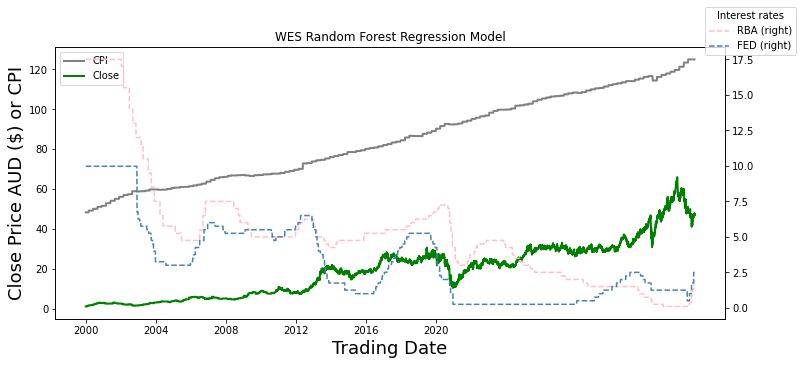

In [40]:
x = np.arange(2000,2024,4)
ax = df_mongo.plot(y=["CPI","Close"], figsize=(12, 5),color=['grey','green'],linewidth=2)
df_mongo.plot(y=["RBA","FED"],secondary_y=True, ax=ax,color=['pink','steelblue'],linestyle='dashed')
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=-4, title="Interest rates")
ax.legend(loc='upper left')
ax.set_xticks([0,1000,2000,3000,4000,5000])
ax.set_xticklabels(x, rotation=0)
ax.set_title('WES Random Forest Regression Model')
ax.set_xlabel('Trading Date', fontsize=18)
ax.set_ylabel('Close Price AUD ($) or CPI', fontsize=18)
plt.savefig('../../static/data/images/wes_tree.png')

#Save predicted error to MongoDB

In [41]:
# Module used to connect Python with MongoDb
import pymongo

In [42]:
# The default port used by MongoDB is 27017
# https://docs.mongodb.com/manual/reference/default-mongodb-port/
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

# Define the 'sharesDB' database in Mongo
db = client.sharesDB.companys

name = 'WES'

In [43]:
# query the classroom collection
companys = db.find({
      'model': 'RFR',
      'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62ee2662c9c0d18e1a72a792'), 'model': 'RFR', 'name': 'WES', 'date': '05/08/2022', 'predicted': 45, 'actual': 47, 'difference': -1.7102, 'accuracy': 97.15}


In [44]:
#save last price actual to variable
actual_price = df_mongo.iloc[-1,5]
actual_date = df_mongo.iloc[-1,1] 
actual_price = int(actual_price)
base_accuracy=round(base_accuracy,2)
print(base_accuracy,actual_price,actual_date)


97.18 47 12/08/2022


In [45]:
# Set keys and values of company
predicted = int(Pred_rf)
difference = Pred_rf-actual_price
difference=difference[0]
print(f'date {actual_date},predicted {predicted},actual {actual_price}, difference {difference},accuracy {base_accuracy}')

date 12/08/2022,predicted 45,actual 47, difference -1.91910140497545,accuracy 97.18


In [46]:
# Delete a document from a collection
db.delete_one(
    {'model': 'RFR','name': name}
)


In [47]:
# Insert a document into the 'companys' collection
db.insert_one(
    {
      'model': 'RFR',
      'name': name,
      'date': actual_date,
      'predicted': predicted,
      'actual': actual_price,
      'difference': round(difference,4),
      'accuracy': base_accuracy        
    }
)

# query the classroom collection
companys = db.find({
  'model': 'RFR',
  'name': name,})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62f86d4d5bc1b7bdfbac98f7'), 'model': 'RFR', 'name': 'WES', 'date': '12/08/2022', 'predicted': 45, 'actual': 47, 'difference': -1.9191, 'accuracy': 97.18}
